In [3]:
import keras
from keras.utils import plot_model,to_categorical
from keras.layers import Dense,LSTM,Bidirectional,TimeDistributed,Conv1D,MaxPool1D,Concatenate,Dropout,BatchNormalization,Add
from keras import Model,Input
from keras.layers import Reshape,Flatten
import numpy as np
from sklearn.model_selection import train_test_split
import keras.backend as K
import keras.callbacks as kcallbacks
from sklearn.preprocessing import LabelEncoder
import string
from keras.optimizers import SGD
import warnings
# from lsuv_init import LSUVinit
warnings.filterwarnings('ignore')
import keras
from keras.utils import plot_model,to_categorical
from keras import Model,Input
from keras.layers import Reshape,Flatten
import numpy as np
from sklearn.model_selection import train_test_split
import keras.backend as K
import keras.callbacks as kcallbacks
from sklearn.preprocessing import LabelEncoder
import string
from keras.optimizers import SGD
import warnings
import tensorflow as tf
# from lsuv_init import LSUVinit
warnings.filterwarnings('ignore')
from tensorflow.keras import layers
from keras.layers import Input, Dense, LSTM, merge ,Conv1D,Dropout,Bidirectional,Multiply
from keras.models import Model


from attention_utils import get_activations
from keras.layers import merge
from keras.layers.core import *
from keras.layers.recurrent import LSTM
from keras.models import *

import  pandas as pd
import  numpy as np

# Load Features

In [2]:
X_features=np.load('./feature/X_feature.npy')
y=np.load('./feature/y_pinyin.npy')

In [3]:
X_features.shape

(4704, 50, 57)

In [4]:
y.shape

(4704, 5)

In [5]:
y[0]

array([2, 1, 0, 0, 0])

In [6]:
alphabet_set=list(string.ascii_letters[:26])

In [7]:
alphabet_set.insert(0,'0')

In [8]:
alphabet_set

['0',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z']

## One-hot Encoding

In [9]:
y=to_categorical(y,num_classes=27)

In [10]:
y.shape

(4704, 5, 27)

## split train and test

In [11]:
X_train, X_test, y_train, y_test=train_test_split(X_features,y,test_size=0.1,random_state=2019)

In [12]:
X_train.shape,X_test.shape

((4233, 50, 57), (471, 50, 57))

In [13]:
y_train.shape,y_test.shape

((4233, 5, 27), (471, 5, 27))

# Models


In [4]:
NUM_CLASSES=27
BATCH_SIZE=128
EPOCHS=100
MODEL_SAVE_PATH='./models/pinyin_cnn.h5'

In [5]:
# main
SINGLE_ATTENTION_VECTOR = False
def attention_3d_block(inputs, single_attention_vector=False):
    # 如果上一层是LSTM，需要return_sequences=True
    # inputs.shape = (batch_size, time_steps, input_dim)
    time_steps = K.int_shape(inputs)[1]
    input_dim = K.int_shape(inputs)[2]
    a = Permute((2, 1))(inputs)
    a = Dense(time_steps, activation='softmax')(a)
    if single_attention_vector:
        a = Lambda(lambda x: K.mean(x, axis=1))(a)
        a = RepeatVector(input_dim)(a)

    a_probs = Permute((2, 1))(a)
    # 乘上了attention权重，但是并没有求和，好像影响不大
    # 如果分类任务，进行Flatten展开就可以了
    # element-wise
    output_attention_mul = Multiply()([inputs, a_probs])
    return output_attention_mul

def attention_model():
    inputs = Input(shape=(50, 57))

    x = Conv1D(filters = 64, kernel_size = 1, activation = 'relu')(inputs)  #, padding = 'same'
    x = Dropout(0.3)(x)

    #lstm_out = Bidirectional(LSTM(lstm_units, activation='relu'), name='bilstm')(x)
    #对于GPU可以使用CuDNNLSTM
    lstm_out = Bidirectional(LSTM(64, return_sequences=True))(x)
    lstm_out = Dropout(0.3)(lstm_out)
    attention_mul = attention_3d_block(lstm_out)
    attention_mul = MaxPool1D(pool_size=41, strides=2)(attention_mul)
    output = Dense(27, activation='sigmoid')(attention_mul)
    model = Model(inputs=[inputs], outputs=output)
    return model

In [6]:
model = attention_model()
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50, 57)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 50, 64)       3712        input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 50, 64)       0           conv1d[0][0]                     
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 50, 128)      66048       dropout[0][0]                    
_______________________________________________________________________________________

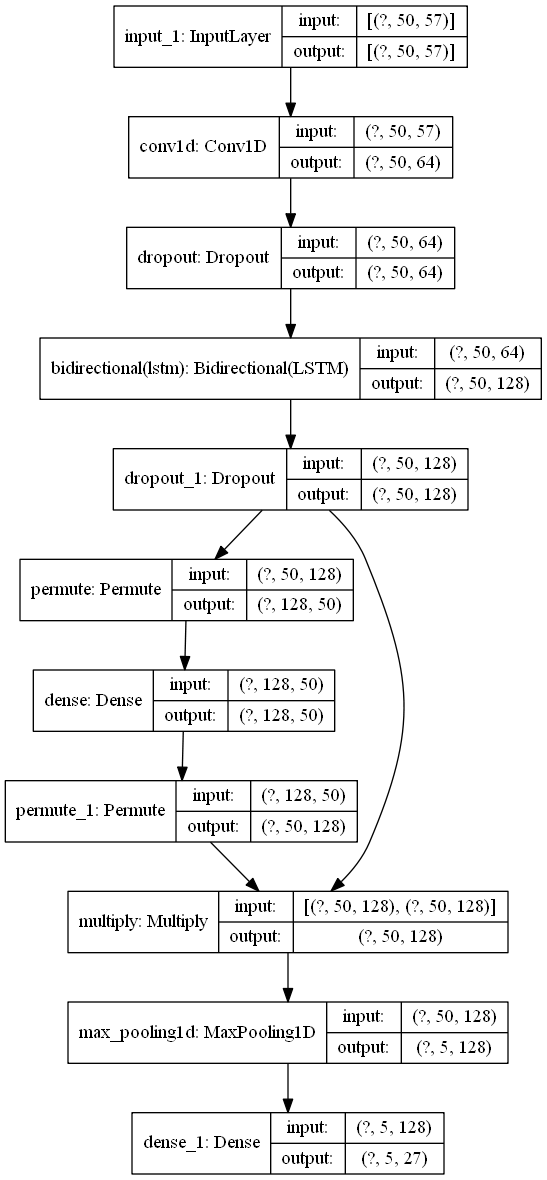

In [8]:
import pydotplus
import graphviz 
from keras.utils import plot_model
plot_model(model, to_file='.\\audio_Pinyin.png', show_shapes=True)

In [17]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
plot_model(model,'model_pinyin.jpg',show_shapes=True)
lr_reduce=kcallbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=6,verbose=1,min_lr=0.00001)
save_model=kcallbacks.ModelCheckpoint(filepath=MODEL_SAVE_PATH,monitor='val_accuracy',verbose=1,save_best_only=True)
callback_list=[save_model,lr_reduce]
history=model.fit(x=X_train,y=y_train,batch_size=BATCH_SIZE,epochs=EPOCHS,validation_data=(X_test,y_test),
                  callbacks=callback_list)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')
Epoch 1/100
33/34 [============================>.] - ETA: 0s - loss: 3.1450 - accuracy: 0.3492
Epoch 00001: val_accuracy improved from -inf to 0.38896, saving model to ./models\pinyin_cnn.h5
34/34 [==============================] - 3s 94ms/step - loss: 3.1443 - accuracy: 0.3494 - val_loss: 2.8879 - val_accuracy: 0.3890
Epoch 2/100
33/34 [============================>.] - ETA: 0s - loss: 2.6449 - accuracy: 0.3772
Epoch 00002: val_accuracy did not improve from 0.38896
34/34 [==============================] - 2s 65ms/step - loss: 2.6447 - accuracy: 0.3772 - val_loss: 2.5935 - val_accuracy: 0.3890
Epoch 3/100
33/34 [============================>.] - ETA: 0s - loss: 2.4991 - accuracy: 0.3772
Epoch 00003: val_accuracy did not improve from 0.38896
34/34 [==============================] - 2s 64ms/step - loss: 2.4989 - accuracy: 0.3772 - val_loss: 2

## plot_curve

In [18]:
from help import plot_curve,plot_curve_with_smooth

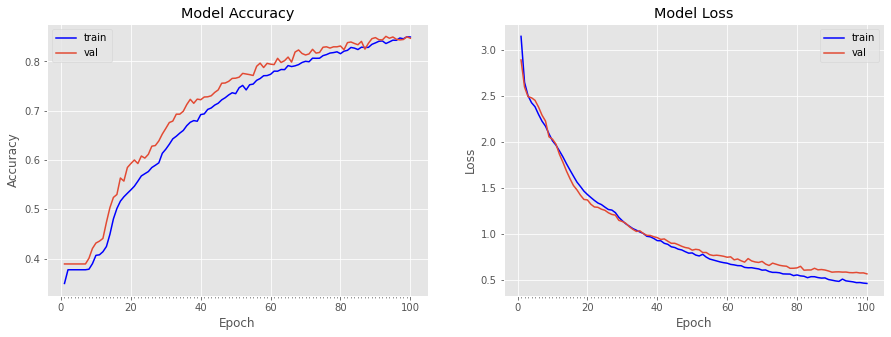

In [19]:
plot_curve(history)

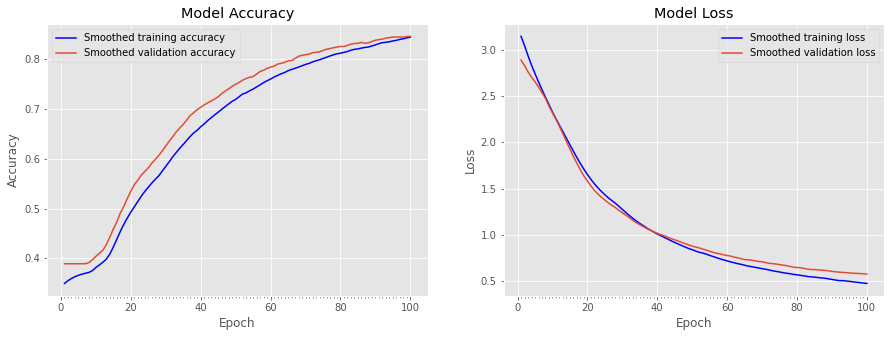

In [20]:
plot_curve_with_smooth(history)

## confusion_metrix

In [20]:
model.load_weights('./models/pinyin_cnn.h5')

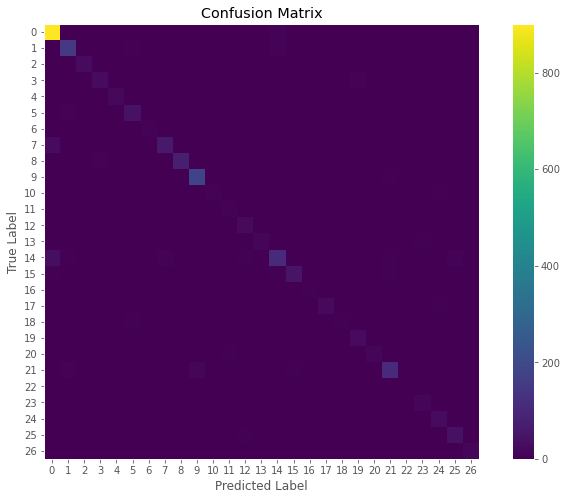

In [21]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
y_pred=model.predict(X_test)
y_pred=np.argmax(y_pred,axis=-1).ravel()
y_true=np.argmax(y_test,axis=-1).ravel()
con_matrix=confusion_matrix(y_true=y_true,y_pred=y_pred)
def plot_confusion_matrix(confusion_mat):
    plt.figure(figsize=(12,8))
    plt.imshow(confusion_mat)
    plt.title('Confusion Matrix')
    plt.colorbar()
    labels = list(range(0,27))
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels)
    plt.yticks(tick_marks, labels)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.grid(False)
    plt.show() 
plot_confusion_matrix(con_matrix)

## classfication_report

In [22]:
from sklearn.metrics import classification_report
#model.load_weights('./models/pinyin_cnn.h5')

In [23]:
target_names=[alphabet_set[i] for i in range(27)]
print(classification_report(y_true,y_pred,digits=4,labels=list(range(27)),target_names=target_names))

              precision    recall  f1-score   support

           0     0.9203    0.9836    0.9509       916
           a     0.8287    0.8571    0.8427       175
           b     0.7353    0.8621    0.7937        29
           c     0.7027    0.7429    0.7222        35
           d     0.8000    0.8000    0.8000        25
           e     0.7719    0.6984    0.7333        63
           f     1.0000    0.7273    0.8421        11
           g     0.8000    0.6122    0.6936        98
           h     0.9157    0.7525    0.8261       101
           i     0.8829    0.9235    0.9027       196
           j     0.7500    0.5625    0.6429        16
           k     0.6250    0.8333    0.7143        12
           l     0.6053    0.8519    0.7077        27
           m     0.6818    0.6818    0.6818        22
           n     0.8116    0.6054    0.6935       185
           o     0.8305    0.7000    0.7597        70
           p     0.5556    0.5000    0.5263        10
           q     0.7586    

# predict test

In [24]:
import librosa
import sklearn
def get_mfcc_feature(path,maxlen=50):
    x, sr = librosa.load(path)
    # extract mfcc
    mfcc = librosa.feature.mfcc(x, sr=sr)
    # Center to the mean and component wise scale to unit variance
    mfcc = sklearn.preprocessing.scale(mfcc, axis=1)
    mfcc_diff = np.diff(mfcc, axis=0)
    mfcc_diff_diff = np.diff(mfcc_diff, axis=0)
    # concatenate mfcc,mfcc_diff and mfcc_diff_diff
    mfccs = np.concatenate([mfcc, mfcc_diff, mfcc_diff_diff], axis=0).T
    #pad the mfccs_feature
    if mfccs.shape[0]<maxlen:
        mfccs=np.concatenate([mfccs,np.zeros((maxlen-mfccs.shape[0],57))],axis=0)
    return mfccs

In [25]:
wav_file='./voice_data/person10_time1_group1_er_4.wav'
test=get_mfcc_feature(path=wav_file)
test=np.expand_dims(test,axis=0)
pred=model.predict(test)
pred=np.argmax(pred,axis=-1)[0]
text=[alphabet_set[i] for i in pred]
text=[i for i in text if i!='0']
text=''.join(text)
print('Predict Label:%s'%(text))

Predict Label:er


In [26]:
wav_file='./voice_data/person10_time1_group1_huo_3.wav'
test=get_mfcc_feature(path=wav_file)
test=np.expand_dims(test,axis=0)
pred=model.predict(test)
pred=np.argmax(pred,axis=-1)[0]
text=[alphabet_set[i] for i in pred]
text=[i for i in text if i!='0']
text=''.join(text)
print('Predict Label:%s'%(text))

Predict Label:huo


In [28]:
wav_file='./voice_data/person10_time1_group2_kou_3.wav'
test=get_mfcc_feature(path=wav_file)
test=np.expand_dims(test,axis=0)
pred=model.predict(test)
pred=np.argmax(pred,axis=-1)[0]
text=[alphabet_set[i] for i in pred]
text=[i for i in text if i!='0']
text=''.join(text)
print('Predict Label:%s'%(text))

Predict Label:kuo
